## Regression Model Development

<b>Student</b>: Gustavo A. Trigos 

<b>Class Cohort</b>: MsBA3

<b>Class</b>: Machine Learning - DAT5303

<b>Assignment Objective</b>: using the information in the Apprentice Chef's Case to build a predictive model on a continous response variable (Revenue generated by a customer within their first year of orders). 

## Libraries

In [1]:
import time
# Start time including loading the libraries
start = time.time()

In [2]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# Statistic tests
from scipy import stats

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Regression Models
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import r2_score

# Misc
import gender_guesser.detector as gender

In [3]:
# setting random seed
rand.seed(a = 219)

## Loading Data

In [4]:
# Loading the Apprentice Chef data set
df = pd.read_excel(io='./datasets/Apprentice_Chef_Dataset.xlsx')
dictionary = pd.read_excel(io='./datasets/Apprentice_Chef_Data_Dictionary.xlsx')

In [5]:
# Renaming column Largest order size to average meals ordered as indicated in the dictionary
df.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_MEALS_ORDERED'}, inplace=True)

## Data Preprocessing

### Missing Values

In [6]:
# Looking into columns with any missing values
df.isna().sum()[df.isna().sum() > 0]

FAMILY_NAME    47
dtype: int64

Given the only column with missing values is an identifier column with no significant value to the analysis, we abstain from imputating missing values to this column.

In [7]:
# Dropping columns with missing values
df.drop(['FAMILY_NAME'],axis=1, inplace=True)

### Splitting Data into Numerical Data and Categorical

In [8]:
# Select all features excluding 'object' or categorical data
df_num = df.select_dtypes(exclude = 'object').copy()
df_cat = df.select_dtypes(include = 'object').copy()

In [9]:
# Excluding Revenue (Y-variable) from main analysis
df_response = df_num[['REVENUE']]
df_num.drop('REVENUE',axis=1,inplace=True)

## Numerical Data: Linear Regression Assumptions for dependent variables

### Outliers

In [10]:
# Interquantile Range method: removing values below or above the IQR * 1.5 thresholds

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

df_num[~((df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))).any(axis=1)].shape

(855, 23)

In [11]:
# Z-score method: removing values with absolute Z-score greater than 3
z_score_condition = np.abs(stats.zscore(df_num)) < 3
df_num[z_score_condition.all(axis = 1)].shape

(1721, 23)

In [12]:
# Number of features where customer is an outlier
num_outliers = pd.DataFrame(z_score_condition).sum(axis=1)

We use two different methods for outlier detection, the first one detects outliers by using the interquantile range (IQR) method of identifying all the values that surpass their respective distribution's IQR below their first quartile minus the IQR times 1.5 or above their third quartile plus the IQR times 1.5. The second method converts all the values in Z-scores and takes all those that are greater than absolute 3. We chose the second method since it was detecting less outliers and was a more conservative approach.

### Linearity between dependent and independent variables

In [13]:
# Correlation between dependent variable and independent variables
df_num.join(df_response).corr()[['REVENUE']].sort_values(by='REVENUE',ascending=False).round(decimals=4).T

,REVENUE,AVG_PREP_VID_TIME,MEDIAN_MEAL_RATING,TOTAL_MEALS_ORDERED,TOTAL_PHOTOS_VIEWED,MASTER_CLASSES_ATTENDED,AVG_MEALS_ORDERED,AVG_TIME_PER_SITE_VISIT,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,TASTES_AND_PREFERENCES,CROSS_SELL_SUCCESS,REFRIGERATED_LOCKER,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,MOBILE_LOGINS,CANCELLATIONS_AFTER_NOON,UNIQUE_MEALS_PURCH,AVG_CLICKS_PER_VISIT
REVENUE,1.0,0.6436,0.6079,0.6005,0.466,0.449,0.4351,0.1446,0.1017,0.0345,...,0.0078,0.0045,-0.0003,-0.0009,-0.0086,-0.0106,-0.0192,-0.0361,-0.0628,-0.5538


We can observe that there are various features that do not have strong absolute correlation coefficients with the dependent variable. It is important to observe the scatterplot for each of the features together with the independent value to make sure that each of the features follow the assumptions of ordinary least square regression.

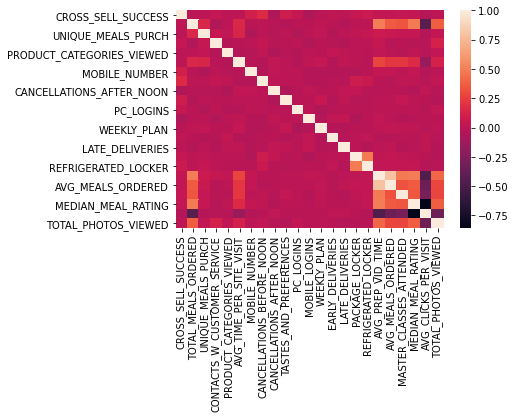

In [14]:
# Correlation Matrix Heatmap
sns.heatmap(df_num.corr())

We use a heatmap to observe the overall linear relationship between every pair of variable. In this case, we do not observe significant levels of multicolinearity. We can observe relatively strong correlation values between independent variables (see total meals ordered with average clicks per visit, master classes attended, and average prep video time). However, with domain knowledge, we know that these variables are not related directly and thus assume that strong correlation values happen due to chance. 

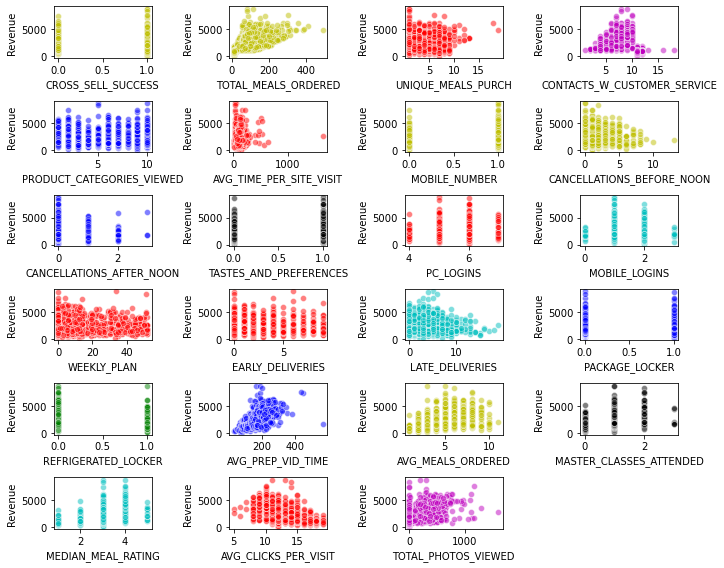

In [15]:
# Scatterplot visualization with dependent variable and independent variables 

def visual_scatter(df,response):
    # setting figure size
    fig, ax = plt.subplots(figsize = (10, 8))
    colors = ['b','g','r','c','m','y','k']

    for idx,col in enumerate(df.columns.values):
        idx += 1

        # developing a scatterplot
        plt.subplot(6,4, idx)
        sns.scatterplot(x = df[col],
                        y = response.loc[df.index],
                        color = rand.choice(colors),alpha=0.5)


        # adding labels
        plt.xlabel(xlabel = '{}'.format(col))
        plt.ylabel(ylabel = 'Revenue')
    

# cleaning up the layout and displaying the plots
# visual_scatter(df_num,df_response['REVENUE'])
plt.tight_layout()
plt.show()

Observing non-linear behavior in various of the relationships between the dependent and independent variables, it will be beneficial to do natural log transform for most if not all of the variables. This will also significantly help with variables that are suffering with heteroscedasticity. 

### Normality in dependent and independent variables

In [16]:
# Creating empy dataframe
normal_test = pd.DataFrame()

# Pre-determined level of confidence for statistical significance tests
alpha = 0.05

for col in df_num.columns:
    
    normal_test.loc[col,'P-Value'] = stats.shapiro(df_num[col]).pvalue
    normal_test.loc[col,'Normal'] = normal_test.loc[col ,'P-Value'] < alpha

# Check if all columns passed the Shapiro-Wilk test (if all columns are non-normal)
normal_test['Normal'].all()

True

We chose the Shapiro-Wilk test for normality, which assumes the null hypothesis to be that a distribution is normal, and the alternative hypothesis to be that the distribution is not normal. The Shapiro-Wilk test rejected the null hypothesis for all of the variables, meaning that the variables do not follow the assumption of normality. Because of this, non-parametric methods like KNN Regression could have better performance in the regression analysis. Additionally, applying natural logarithmic transformations could also help making the distribution approximately normal.

In [17]:
# Computing distribution moments for each feature
normal_stats = pd.DataFrame({'mean':df_num.mean(),'median':df_num.median(),'skewness':df_num.skew(),'kurtosis':df_num.kurt()})
# normal_stats

Additional analysis was made by looking into key moments of the distribution for each of the variables to understand the shape of their respective distributions. We used the mean and the median to see differences between them, and we used skewness and kurtosis to understand the magnitude and direction of the skewness of the variable and the tails of the distribution. In most of the cases, we saw strong non-normal characteristics.

### Transformation and Normalization

In [18]:
# Transform data to log transform
log_cols = ['TOTAL_MEALS_ORDERED',
'UNIQUE_MEALS_PURCH',
'CONTACTS_W_CUSTOMER_SERVICE',
'PRODUCT_CATEGORIES_VIEWED',
'AVG_TIME_PER_SITE_VISIT',
'CANCELLATIONS_BEFORE_NOON',
'WEEKLY_PLAN',
'EARLY_DELIVERIES',
'LATE_DELIVERIES',
'AVG_PREP_VID_TIME',
'AVG_MEALS_ORDERED',
'MEDIAN_MEAL_RATING',
'AVG_CLICKS_PER_VISIT',
'TOTAL_PHOTOS_VIEWED'] 

# Creating new columns with new log prefix and natural logarithm transformation.
for col in log_cols:
    # Adding constant 1 to avoid transforming log of zero
    df_num.loc[:,'log_'+col] = np.log(df_num[col]+1)

In [19]:
# Dropping original values after being transformed
df_num.drop(log_cols,axis=1,inplace=True)

Looking into the scatterplot between the independent variable and the dependent variable, we believe continuous features and a selected set of discrete values can benefit from natural log-transformation. The transformations will  help each of the distribution to approximately conform to a normal distribution, as well as creating a stronger linear relationship with the response variable by mitigating heteroscedasticity. We then removed the original columns and replace them with the transformed columns. 

In [20]:
# Adding extra columns with number of outlier detection
#df_num = df_num.join(outlier_features)
df_num['OUTLIERS_NUM'] = num_outliers

In [21]:
# Creating binary data to encompass those who have viewed photos vs. those who have not
df_num['SEEN_PHOTOS'] = (df_num['log_TOTAL_PHOTOS_VIEWED']==0).astype('int')

In [22]:
# Normalize data with Min-Max Scaler with a range of 0 to 1
df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_num))
df_norm.set_index(df_num.index, inplace = True)

df_norm.columns = df_num.columns

We scale all of the variables with the Min-Max scaler and set the new range from zero to one. This scale will help us interpret the coefficients in the same scale, and help some of the distance-based models to process correctly (like the KNN model).

## Categorical Data

In [23]:
# Subsetting observations from numerical data 
df_cat = df_cat.loc[df_norm.index]

### Names and Gender

In [24]:
# guessing gender based on (given) name

def gender_guesser():
    # placeholder list
    placeholder_lst = []

    # looping to guess gender
    for name in df_cat.loc[:,'FIRST_NAME']:
        guess = gender.Detector(case_sensitive=False).get_gender(name)
        print(guess)
        placeholder_lst.append(guess)
    
    return placeholder_lst

# converting list into a series
# placeholder_lst = gender_guesser()
#pd.Series(placeholder_lst).to_csv('name_gender_guesser.csv')

We use a gender detector library to classify the gender of each observation with a given first name. Due to processing time, we ran the code one time and saved the results into a csv file.

In [25]:
# Loading gender guess csv
gender_guess = pd.read_csv('./name_gender_guesser.csv')
df_cat['GENDER_GUESS'] = pd.Series(gender_guess['GENDER_GUESS'])

In [26]:
# Observing proportions for the first time
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

unknown          0.57
male             0.15
female           0.05
mostly_male      0.01
mostly_female    0.01
andy             0.00
Name: GENDER_GUESS, dtype: float64

In [27]:
# Assigning classes
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_female') ,'GENDER_GUESS'] = 'female'
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_male') ,'GENDER_GUESS'] = 'male'

# int assignment
female = 1
male = 0

df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [28]:
unknown_condition = (df_cat['GENDER_GUESS'] == 'unknown') 

# Create dummy variable for unknown gender
df_cat['GENDER_UNKNOWN'] = unknown_condition.astype('int')

# All surnames that are unknown and end with 'a' are assigned female
a_condition = df_cat['FIRST_NAME'].str.endswith('a')
df_cat.loc[((unknown_condition & a_condition)),'GENDER_GUESS'] = 'female'
           
# All surnames that are unknown and end with 'o' are assigned to male 
o_condition = df_cat['FIRST_NAME'].str.endswith('o')
df_cat.loc[((unknown_condition & o_condition)),'GENDER_GUESS'] = 'male'         

In [29]:
# Revising how proportions changed
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

unknown    0.49
male       0.18
female     0.12
Name: GENDER_GUESS, dtype: float64

In [30]:
# Adding random choice to all the variables that are unknown
df_cat.loc[unknown_condition ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[unknown_condition ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [31]:
# Revising final proportions
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

male      0.45
female    0.33
Name: GENDER_GUESS, dtype: float64

In [32]:
# Changing to binary variable
df_cat['GENDER_GUESS'] = df_cat['GENDER_GUESS'].replace('female',female).replace('male',male)

In [33]:
# Filling remaining NA with male (given known proportions were skewed towards male)
df_cat['GENDER_GUESS'].fillna(female, inplace=True)




We used the gender_guesser library to estimate the gender of each of the customers by using their first name. The majority of the names, however, resulted with unknown genders. For those observations that were classified as "mostly_female" and "mostly_male", we assigned them to the "female" and "male" classes respectively. For those observations with "andy", given the algorithm found that the names could be assigned either for female or male, we used the numpy random integer generator to create an array of random binary classes and assign those observations with 1 for "female" and 0 for "male". For the unknown genders, we decided to first create a dummy variable that contains information of which gender was unknown, and then fill those that were unknown but that their first name finished with 'a' or 'o' to female and male respectively. With this, we had 50% of the observations to be unknown, with this, then we decided to run the same random choice method from above to assign the remaining variables as either "female" or "male." 

### Email Classification

In [34]:
# Creating Email Domain column by spliting email from '@' character
df_cat['EMAIL_DOMAIN'] = '@' + df_cat['EMAIL'].str.split('@',expand=True)[1]

In [35]:
professional_email = ['@mmm.com' 
            ,'@amex.com' 
            ,'@apple.com'
            ,'@boeing.com'
            ,'@caterpillar.com' 
            ,'@chevron.com' 
            ,'@cisco.com' 
            ,'@cocacola.com' 
            ,'@disney.com' 
            ,'@dupont.com' 
            ,'@exxon.com' 
            ,'@ge.org'
            ,'@goldmansacs.com'
            ,'@homedepot.com' 
            ,'@ibm.com' 
            ,'@intel.com' 
            ,'@jnj.com'
            ,'@jpmorgan.com'
            ,'@mcdonalds.com' 
            ,'@merck.com' 
            ,'@microsoft.com'
            ,'@nike.com' 
            ,'@pfizer.com' 
            ,'@pg.com' 
            ,'@travelers.com'
            ,'@unitedtech.com'
            ,'@unitedhealth.com' 
            ,'@verizon.com' 
            ,'@visa.com' 
            ,'@walmart.com']

personal_email = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com', '@passport.com']

In [36]:
# Professional Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(professional_email),'EMAIL_CLASS'] = 'professional'

# Personal Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(personal_email),'EMAIL_CLASS'] = 'personal'

# Junk Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(junk_email),'EMAIL_CLASS'] = 'junk'

In [37]:
# Email class proportions
(df_cat['EMAIL_CLASS'].value_counts() / df_cat.shape[0]).round(2)

personal        0.44
professional    0.36
junk            0.20
Name: EMAIL_CLASS, dtype: float64

In [38]:
# Creating one-hot-encoding for Email Class column, deletes one class (K - 1)
df_cat = df_cat.join(pd.get_dummies(df_cat['EMAIL_CLASS'], drop_first = True))

In [39]:
# Cleaning columns that are irrelevant
df_cat.drop(['NAME','EMAIL','FIRST_NAME','EMAIL_DOMAIN','EMAIL_CLASS'],axis=1, inplace=True)

With the email variable, we used information from the case to obtain a list of those emails that were considered as professional, personal, or junk. We used different string methods to split the email variable and obtain the domain of the email only. With this information, we then classified those observations with their domains to each of their respective buckets ("professional", "personal", or "junk"). We expect this classification to give us further information about the customer profile. We then converted the variable into a dummy variable of those that are "personal" and those that are "junk", and dropped the "personal" column to use it as the baseline class in the models. 

## Feature Engineering

In [40]:
# Joining number data with categorical data, then separating features from the target value.
df_features = df_cat.join(df_norm)

### Domain Knowledge Features

In [41]:
## Average Number of Unique Meals per order 
df_features['MEALS_PER_ORDER'] = df_features['log_TOTAL_MEALS_ORDERED'] / df_features['log_UNIQUE_MEALS_PURCH']

# TOTAL_PHOTOS_VIEWED per total logins
df_features['PHOTOS_VIEWED_LOGIN'] = df_features['log_TOTAL_PHOTOS_VIEWED'] / (df_features['MOBILE_LOGINS'] + df_features['PC_LOGINS'])

# LATE_DELIVERIES  per CONTACTS_W_CUSTOMER_SERVICE
df_features['LATE_DELIVERIES_CUSTOMER'] = df_features['log_LATE_DELIVERIES'] / df_features['log_CONTACTS_W_CUSTOMER_SERVICE']

# MEDIAN_MEAL_RATING per AVG_PREP_VID_TIME
df_features['RATING_VID_TIME'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_AVG_PREP_VID_TIME']

# AVG_MEALS_ORDERED per AVG_TIME_PER_SITE_VISIT
df_features['ORDERS_PER_VISIT'] = df_features['log_AVG_MEALS_ORDERED'] / df_features['log_AVG_TIME_PER_SITE_VISIT']

# MEDIAN_MEAL_RATING per EARLY_DELIVERIES 
df_features['RATING_EARLY_DELIVERIES'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_EARLY_DELIVERIES']

# MASTER_CLASSES_ATTENDED per AVG_PREP_VID_TIME
df_features['CLASS_PER_VID_TIME'] = df_features['MASTER_CLASSES_ATTENDED'] / df_features['log_AVG_PREP_VID_TIME']


In [42]:
# Making sure inf values turn into nan
df_features.replace([np.inf, -np.inf], np.nan,inplace=True)
df_features.fillna(0,inplace=True)

Looking into the case, we were able to find additional information about the customer journey framework, the master cooking classes, operation processes and pipeline, ordering platform characteristics, and customer service experience. With this, we were able to add additional features (mostly ratios) into the processed dataset: <b>1) unique meals per order,</b> by dividing the total meals ordered with the unique meals purchased, we can obtain additional information about the average number of unique meals ordered per customer; <b>2) photos viewed per total login</b>, by dividing total photos viewed with the sum of the mobile and PC logins, we obtained additional information of the number of pictures that a customer sees every time he or she logs in the platform; <b>3) late deliveries per contact with customer service</b>, this new variable can tell us the proportion of those that had late deliveries and that had a contact with customer services; <b>4) median meal rating per average prep video time</b>, this variable tells us the proportion of the ratings with the time it takes to observe the preparation video; <b>5) meals ordered per time per site visit</b>, this variable tells us how many meals are being ordered per the average time a customer spends on the platform when they visit it; <b>6) median meal rating per early deliveries</b>, this variable helps us explore the relationship of how the ratings change with the number of times a customer receives an order early; <b>7) class attended per prep video time</b>, this variables tells us the amount of classes that a customer attended in respect with the amount that the preparation video took.

### Interactions

In [43]:
# Create every possible bivariate combination to be tested for feature engineering
from itertools import combinations

interaction_list = ['log_TOTAL_MEALS_ORDERED',
'log_UNIQUE_MEALS_PURCH',
'log_CONTACTS_W_CUSTOMER_SERVICE',
'log_PRODUCT_CATEGORIES_VIEWED',
'log_AVG_TIME_PER_SITE_VISIT',
'log_CANCELLATIONS_BEFORE_NOON',
'log_WEEKLY_PLAN',
'log_EARLY_DELIVERIES',
'log_LATE_DELIVERIES',
'log_AVG_PREP_VID_TIME',
'log_AVG_MEALS_ORDERED',
'log_MEDIAN_MEAL_RATING',
'log_AVG_CLICKS_PER_VISIT',
'log_TOTAL_PHOTOS_VIEWED']

interactions = list(combinations(interaction_list, 2))

In [44]:
# Iterate through interaction list to perform linear regression for each possible engineered features
for interaction in interactions:
    df_features['{}_{}'.format(interaction[0],interaction[1])] = df_features[interaction[0]] * df_features[interaction[1]]

df_features.shape

(1946, 127)

For additional variables, we decided to introduce the interactions of continuous, and a selected number of count and interval, variables to create new features with the potential where the magnitude of existing variables depends on other variables, assuming constant direction for the first variables. In it, we used the library of itertools to find all the potential combinations between the selected variables to create interactions between them.  

## Train-Test Split

In [45]:
# Dividing dataset into dependent and independent variables
X = df_features
y = pd.Series(data=np.log(df_response['REVENUE'] + 1).values, name='log_REVENUE')

# Splitting the dataset into 75% Trainning and 25% Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 219)

## Predictive Model Development

In [46]:
# Defining a function to output metrics

def metrics(model,X_train,y_train,X_test,y_test):
    
    # FITTING the training data
    model_fit = model.fit(X_train,y_train)


    # PREDICTING on new data
    model_pred = model_fit.predict(X_test)

    # saving scoring data for future use
    model_train_score = model.score(X_train,y_train).round(decimals = 4)
    model_test_score  = model.score(X_test,y_test).round(decimals = 4)
    model_test_gap = abs(model_train_score - model_test_score).round(decimals = 4)
    
    # Saving coefficients in list
    
    try:
        # Zipping each feature name to coefficient
        model_values = zip(X_train.columns, model_fit.coef_.round(decimals = 7))

        # setting up a placeholder list to store model features
        model_lst = [('intercept', model_fit.intercept_.round(decimals = 7))]

        # Appending coefficients to model list
        for val in model_values:
            if (val[1] != 0):
                model_lst.append(val)
    
    except:
        model_lst = []
    
    return model_train_score, model_test_score, model_test_gap, model_lst
    

### Statsmodel Multiple Linear Regression(OLS Regression)

In [47]:
# Instantiating Statsmodel OLS Linear Regression model
variables = "+".join(X_train.columns)
formula = 'log_REVENUE ~ ' + variables

stats_regression = smf.ols(formula = formula,data = X_train.join(y_train))

# telling Python to FIT the data to the blueprint
results = stats_regression.fit()

# printing a summary of the results
# results.summary()

### Multiple Linear Regression (OLS Regression)

In [48]:
# Instantiating OLS Linear Regression model
linear_regression = LinearRegression()

### Lasso Regression (L1 Regularization)

In [49]:
# Instantiating Lasso Regression model (Starting alpha value of 0.1)
lasso_regression = Lasso(alpha=0.0003)

### Bayesian Automatic Relevance Determination (ARD)

In [50]:
# Instantiating ARD Regression model
ARD_regression = ARDRegression()

### K-Nearest Neighbors Regression (KNN)

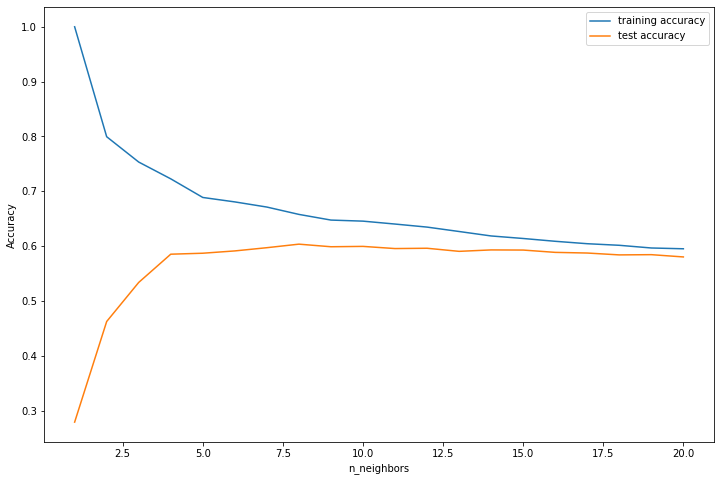

The optimal number of neighbors is 8


In [51]:
def KNN_tuning():
    
    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []


    # building a visualization of 1 to 50 neighbors
    neighbors_settings = range(1, 21)


    for n_neighbors in neighbors_settings:
        # Building the model
        clf = KNeighborsRegressor(n_neighbors = n_neighbors)
        clf.fit(X_train, y_train)

        # Recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))

        # Recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # plotting the visualization
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
    plt.plot(neighbors_settings, test_accuracy,     label = "test accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.legend()
    plt.show()


    # finding the optimal number of neighbors
    opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
    print(f"""The optimal number of neighbors is {opt_neighbors}""")
    
    return opt_neighbors

# opt_neighbors = KNN_tuning()

In [52]:
# Instantiating KNN Regression model (Starting with a K of 5)
opt_neighbors = 7 # Hard coding the optimal number to avoid re-running the hyperparameter tuning
KNN_regression = KNeighborsRegressor(n_neighbors=opt_neighbors)

We decided to utilize four different regression models. The first regression model is the <b>ordinary least squares (OLS)</b> multiple regression model, which aims to estimate the unknown population parameters of a linear regression by minimizing the squared sum of the differences between the observed dependent variable  in the given dataset and those predicted by the regression line. <b>The Lasso (L1) </b> regression model follows the same conventions of the OLS model but adds a regularization component that performs feature selection by zeroing-out features that are deemed irrelevant or redundant. These models are subject to various assumptions where the residuals of the models, the independent variables, and the dependent variables must comply with certain characteristics for the linear equation to be statistically significant. We also used the <b>Automatic Relevance Determination regression model (ARD) </b>and the <b>K-Nearest Neighbor regression model (KNN)</b>. the ARD model uses the Bayes theorem and shifts the coefficient weights toward zeros, to stabilize certain variables. At last, the KNN model is a non-parametric method that approximates the association between independent variables and the continuous outcome by averaging the observations that are closest to the point being tested. 

## Model Performance Comparison

In [53]:
# Runnign function gather score of models
linear_train_score, linear_test_score, linear_test_gap, linear_model_lst = metrics(linear_regression,X_train,y_train,X_test,y_test)
lasso_train_score, lasso_test_score, lasso_test_gap, lasso_model_lst = metrics(lasso_regression,X_train,y_train,X_test,y_test)
ARD_train_score, ARD_test_score, ARD_test_gap, ARD_model_lst = metrics(ARD_regression,X_train,y_train,X_test,y_test)
KNN_train_score, KNN_test_score, KNN_test_gap, KNN_model_lst = metrics(KNN_regression,X_train,y_train,X_test,y_test)

In [54]:
# creating a dictionary to store model results
model_performance = {
    
    'Model Type'    : ['OLS', 'Lasso', 'ARD (Final Model)','KNN'],
           
    'Training Score' : [linear_train_score, lasso_train_score,
                        ARD_train_score, KNN_train_score],
           
    'Testing Score'  : [linear_test_score, lasso_test_score,
                        ARD_test_score, KNN_test_score],
                    
    'Train-Test Gap' : [linear_test_gap, lasso_test_gap,
                                ARD_test_gap, KNN_test_gap],
                    
    'Model Size' : [len(linear_model_lst), len(lasso_model_lst),
                            len(ARD_model_lst), X_train.shape[1]],
                    
    'Model Coefficients' : [linear_model_lst, lasso_model_lst, ARD_model_lst, KNN_model_lst]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)
model_performance

,Model Type,Training Score,Testing Score,Train-Test Gap,Model Size,Model Coefficients
0,OLS,0.8252,0.8030,0.0222,128,"[(intercept, 8.2058622), (GENDER_GUESS, 0.0095..."
1,Lasso,0.8083,0.7972,0.0111,59,"[(intercept, 7.1736216), (GENDER_GUESS, 0.0018..."
2,ARD (Final Model),0.8169,0.8037,0.0132,69,"[(intercept, 7.5433844), (CROSS_SELL_SUCCESS, ..."
3,KNN,0.6713,0.5972,0.0741,127,[]


To compare the performance of each of the models, we built a user defined function that instantiated and fitted a model, and then predicted the testing set with the coefficients computed by the models. From the performance observed in the above table, <b>we have chosen the ARD model as the final and best model</b> due to its testing performance with an R-square of 80.37% and a train-test gap of 0.0132. Additionally, this model was chosen over the OLS model, given the ARD model was more efficient in the use of variables by selecting almost half of the features that the OLS model uses. The ARD model chose 69 coefficients, making the interpretation of the model less complex.

In this case, the chosen ARD model explains 80.37% of the variance of the logarithmic transformation of our response variable (Revenue per customer for their first year).

In [55]:
# Number of Seconds to run the script
end = time.time()
print("Time in Seconds:", round(end - start,2))

Time in Seconds: 18.55
